# Part 2: Text Preprocessing and Baseline Models

## Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import re 
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, 
                            recall_score, precision_score, f1_score, classification_report, log_loss)

# settings
pd.options.display.max_colwidth = 500

## Read in data 

In [198]:
df = pd.read_csv("../data/cyberbullying_tweets.csv")

In [195]:
df.shape

(47692, 2)

# Text preprocessing 

Remove urls and usernames 

In [200]:
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

In [201]:
#remove links 
df['no_links_text'] = [remove_urls(i) for i in df['tweet_text']]

In [6]:
# code from Devin 
Tweet = "Hello@username"
Tweet = re.sub('@[^\s]+','',Tweet)
Tweet

'Hello'

In [202]:
# remove user names and @ symbols 
df['no_links_text'] = df['no_links_text'].map(lambda x: re.sub('@[^\s]+','',x))

In [203]:
# remove ['&amp;', '&lt;&lt;&lt;']
df['no_links_text'] = df['no_links_text'].map(lambda x: re.sub("&lt;&lt;&lt;|&amp;#x200B;|&amp;", ' ', str(x))) 

In [9]:
df.tail()

,tweet_text,cyberbullying_type,no_links_text
47687,"Black ppl aren't expected to do anything, depended on for anything. Yet free to participate, work, enjoy the freedom of humans all across this globe. If you waste your energy on the past you will be wasting it for building the future.",ethnicity,"Black ppl aren't expected to do anything, depended on for anything. Yet free to participate, work, enjoy the freedom of humans all across this globe. If you waste your energy on the past you will be wasting it for building the future."
47688,Turner did not withhold his disappointment. Turner called the court an “abominable conclave of negro hating demons” (with one exception) who “issued another decree that colored men and women must be driven into Jim Crow cars whenever it suits the whim of any white community.”,ethnicity,Turner did not withhold his disappointment. Turner called the court an “abominable conclave of negro hating demons” (with one exception) who “issued another decree that colored men and women must be driven into Jim Crow cars whenever it suits the whim of any white community.”
47689,I swear to God. This dumb nigger bitch. I have got to bleach my hair reeeeeal fuckin' soon. D:&lt; FUCK.,ethnicity,I swear to God. This dumb nigger bitch. I have got to bleach my hair reeeeeal fuckin' soon. D:&lt; FUCK.
47690,"Yea fuck you RT @therealexel: IF YOURE A NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS.",ethnicity,"Yea fuck you RT IF YOURE A NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS."
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK KP that dumb nigger bitch lmao,ethnicity,Bro. U gotta chill RT Dog FUCK KP that dumb nigger bitch lmao


## Export preprocessed dataframe to csv

In [10]:
# df.to_csv('../data/cleaned_tweets.csv', index=False)

## Create 10% sample dataframe for modeling 

In [11]:
df_sample = df.sample(4800, random_state=42)
df_sample.head(1)

,tweet_text,cyberbullying_type,no_links_text
40362,"@Goree_JuhssGuns hahaha he ain't even worth my tweets dumb fuck don't knw the diff between ""nigga"" &amp; ""nigger""",ethnicity,"hahaha he ain't even worth my tweets dumb fuck don't knw the diff between ""nigga"" ""nigger"""


In [12]:
df_sample.tail(1)

,tweet_text,cyberbullying_type,no_links_text
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying,"Yes, we get it. You're pretty. Tone down the self promo and just cook! #MKR"


In [13]:
# df_sample.to_csv('../data/cleaned_tweets_sample.csv', index=False)

In [14]:
df_sample['cyberbullying_type'].value_counts()

age                    809
other_cyberbullying    804
ethnicity              801
not_cyberbullying      801
gender                 800
religion               785
Name: cyberbullying_type, dtype: int64

# Modeling

## Classifier pipelines

Compare text vectorizing methods count vectorizer and term frequency inverse document frequency using logistic regression and naive bayes

### Train test split on sample dataset 

In [18]:
# y = df_sample['cyberbullying_type']
# X = df_sample['no_links_text']

In [19]:
# X.shape

(4800,)

In [20]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Train test split on full dataset

In [36]:
y = df['cyberbullying_type']
X = df['no_links_text']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Count vectorizer

In [38]:
cv_log = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english', min_df=4)), 
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
]) 

cv_log.fit(X_train, y_train)
cv_log.score(X_train, y_train), cv_log.score(X_test, y_test)

(0.9198467947105035, 0.8200117420112388)

In [39]:
cv_mnb = Pipeline([
    ('cv', CountVectorizer(stop_words = 'english', min_df=4)), 
    ('mnb', MultinomialNB())
]) 

cv_mnb.fit(X_train, y_train)
cv_mnb.score(X_train, y_train), cv_mnb.score(X_test, y_test)

(0.8220805725628337, 0.774721127233079)

### TF-IDF 

In [40]:
tf_log = Pipeline([
    ('tf', TfidfVectorizer(stop_words = 'english', min_df=4)), 
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])

tf_log.fit(X_train, y_train)
tf_log.score(X_train, y_train), tf_log.score(X_test, y_test)

(0.8883111073834885, 0.8242891889625095)

In [41]:
tf_mnb = Pipeline([
    ('tf', TfidfVectorizer(stop_words = 'english', min_df=3)), 
    ('mnb', MultinomialNB())
])

tf_mnb.fit(X_train, y_train)
tf_mnb.score(X_train, y_train), tf_mnb.score(X_test, y_test)

(0.8245408034890548, 0.7607145852553887)

## Evaluate classifier models

Compare confusion matrices, accuracy scores

In [69]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
multilabel_confusion_matrix()

In [77]:
def matrix_report(pipeline_list, X_test, y_test):
    
    for model in pipeline_list:
        preds = model.predict(X_test)
        print(f'Accuracy = {round(accuracy_score(y_test, preds), 4)}')
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax, xticks_rotation=45, colorbar=False)
        plt.title({model})
        plt.show(); 
        print(classification_report(y_test, preds))
        print()

    return

Accuracy = 0.82


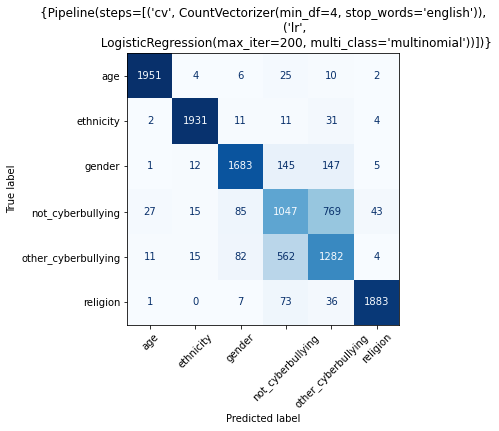

                     precision    recall  f1-score   support

                age       0.98      0.98      0.98      1998
          ethnicity       0.98      0.97      0.97      1990
             gender       0.90      0.84      0.87      1993
  not_cyberbullying       0.56      0.53      0.54      1986
other_cyberbullying       0.56      0.66      0.61      1956
           religion       0.97      0.94      0.96      2000

           accuracy                           0.82     11923
          macro avg       0.82      0.82      0.82     11923
       weighted avg       0.83      0.82      0.82     11923


Accuracy = 0.7747


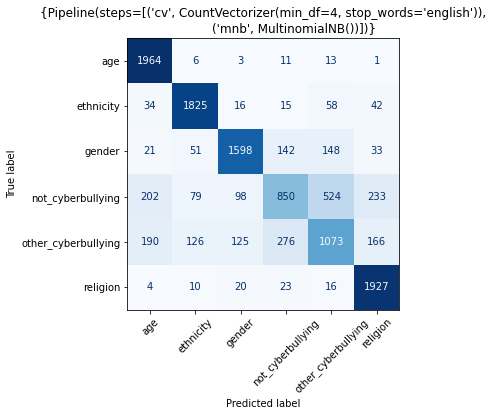

                     precision    recall  f1-score   support

                age       0.81      0.98      0.89      1998
          ethnicity       0.87      0.92      0.89      1990
             gender       0.86      0.80      0.83      1993
  not_cyberbullying       0.65      0.43      0.51      1986
other_cyberbullying       0.59      0.55      0.57      1956
           religion       0.80      0.96      0.88      2000

           accuracy                           0.77     11923
          macro avg       0.76      0.77      0.76     11923
       weighted avg       0.76      0.77      0.76     11923


Accuracy = 0.8243


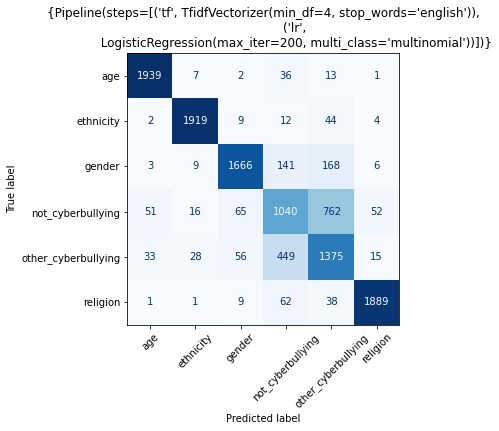

                     precision    recall  f1-score   support

                age       0.96      0.97      0.96      1998
          ethnicity       0.97      0.96      0.97      1990
             gender       0.92      0.84      0.88      1993
  not_cyberbullying       0.60      0.52      0.56      1986
other_cyberbullying       0.57      0.70      0.63      1956
           religion       0.96      0.94      0.95      2000

           accuracy                           0.82     11923
          macro avg       0.83      0.82      0.82     11923
       weighted avg       0.83      0.82      0.83     11923


Accuracy = 0.7607


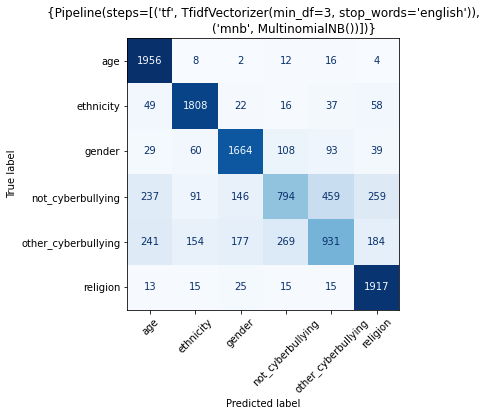

                     precision    recall  f1-score   support

                age       0.77      0.98      0.86      1998
          ethnicity       0.85      0.91      0.88      1990
             gender       0.82      0.83      0.83      1993
  not_cyberbullying       0.65      0.40      0.50      1986
other_cyberbullying       0.60      0.48      0.53      1956
           religion       0.78      0.96      0.86      2000

           accuracy                           0.76     11923
          macro avg       0.75      0.76      0.74     11923
       weighted avg       0.75      0.76      0.74     11923




In [80]:
matrix_report([cv_log, cv_mnb, tf_log, tf_mnb], X_test, y_test)

### Summary of model performance

In [49]:
# Code adapted from Tanya Shapiro's function get_metrics()

def classifier_metrics(report_title, model): 
    '''
    Input a model and calculate predictions with X_test.
    Print a summary of classifier metrics from sklearn.metrics calculated with 
    y_test and preds
    returns df that can be compiled into summary table
    '''
    preds = model.predict(X_test)
    # log_loss_score = log_loss(y_test, preds) 
    # f1 = f1_score(y_test, preds)
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, preds)
    # sensitivity = recall_score(y_test, preds)
    # precision = precision_score(y_test, preds)
    metrics = {
        'model': report_title, 
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy, 
        # 'f1_score': f1, 
        # 'log_loss': log_loss_score, 
        # 'sensitivity': sensitivity, 
        # 'precision': precision
    }
    df = pd.DataFrame(metrics.items()).T
    df.columns = df.iloc[0]
    df = df[1:]
    return df
      

In [139]:
metrics1 = classifier_metrics('CountVectorizer + Multinomial Logistic Regression', cv_log)
metrics2 = classifier_metrics('TF-IDF + Multinomial Logistic Regression', tf_log)
metrics3 = classifier_metrics('CountVectorizer + Multinomial Naive Bayes', cv_mnb)
metrics4 = classifier_metrics('TF-IDF + Multinomial Naive Bayes', tf_mnb)

metrics = pd.concat([metrics1, metrics2, metrics3, metrics4]).sort_values('test_accuracy')
metrics 

,model,train_accuracy,test_accuracy
1,TF-IDF + Multinomial Naive Bayes,0.824541,0.760715
1,CountVectorizer + Multinomial Naive Bayes,0.822081,0.774721
1,CountVectorizer + Multinomial Logistic Regression,0.919847,0.820012
1,TF-IDF + Multinomial Logistic Regression,0.888311,0.824289


In [157]:
# Code from Pedro M Duarte https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot 

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the TITLE 
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


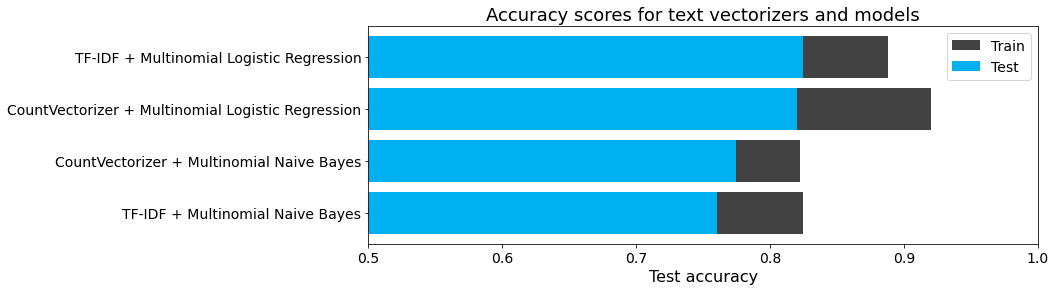

In [220]:
plt.figure(figsize=(12, 4))
plt.xlim(.5, 1)
plt.barh(metrics['model'], metrics['train_accuracy'], label='Train', color='#434343ff')
plt.barh(metrics['model'], metrics['test_accuracy'], label='Test', color='#00b0f0ff')
plt.xlabel('Test accuracy')
plt.title('Accuracy scores for text vectorizers and models')
plt.legend()
plt.savefig('../plots/accuracy_scores.png');

- Count vectorizer + multinomial naive bayes was the least overfit and Count vectorizer + multinomial logistic regression was the most overfit
- TF-IDF + multinomial logistic regression had the highest test accuracy score
- Count vectorizer + multinomial logistic regression was a close second for test highest accuracy

### Optimizing the best model 

- stopwords None vs 'english' and using stopwords improved all 4 model train/test scores 
- min_df = 3 vs 4 and all model train/test score spread, except TF-IDF + MultinomialNB, were improved with min_df = 4

### Export as pickle

In [159]:
tf_log = Pipeline([
    ('tf', TfidfVectorizer(stop_words = 'english', min_df=4)), 
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200))
])

tf_log.fit(X_train, y_train)
tf_log.score(X_train, y_train), tf_log.score(X_test, y_test)

(0.8883111073834885, 0.8242891889625095)

In [35]:
# with open('../models/pickle_tf_log.pkl', 'wb') as pickle_out:
#     pickle_out = pickle.dump(cv_log, pickle_out)
    

### Export confusion matrix figure

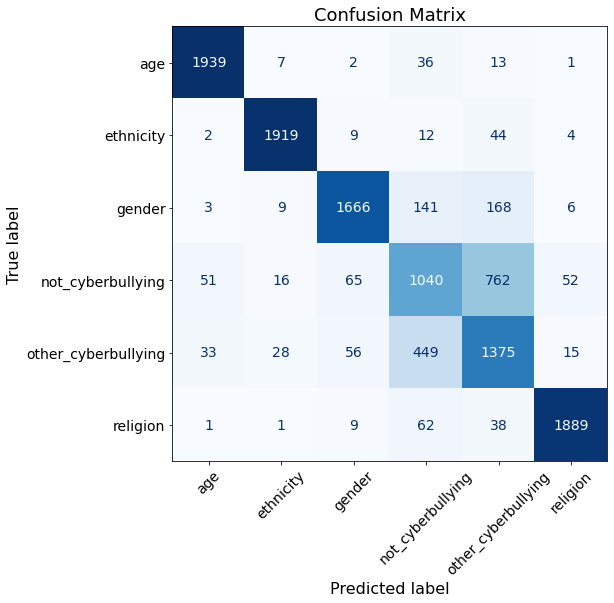

In [191]:
# citation for svg file https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality 

fig, ax = plt.subplots(figsize=(8, 8))
plt.title('Confusion Matrix')
plot_confusion_matrix(tf_log, X_test, y_test, cmap='Blues', xticks_rotation=45, colorbar=False, ax=ax) 
plt.savefig('../plots/tf_log_confusion_matrix.eps', format='eps', dpi=1200, bbox_inches='tight'); 

## Analyze misclassified tweets for the best model 

In [478]:
pred_proba = tf_log.predict_proba(X_test)

In [479]:
pred_proba_df = pd.DataFrame(pred_proba)

In [480]:
preds = tf_log.predict(X_test)
pred_df = pd.DataFrame(preds)

In [350]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head(1)

,cyberbullying_type
803,not_cyberbullying


In [351]:
X_test_df = pd.DataFrame(X_test)
X_test_df.head(1)

,no_links_text
803,You only give half a fuck about sweatshop labor when it's a derail. Bye!


In [352]:
test_df = pd.concat([X_test_df, y_test_df], axis=1)
test_df.reset_index(inplace=True, drop=True)

In [477]:
df_probs = pd.concat([pred_proba_df, pred_df, test_df], axis=1, ignore_index=True)
df_probs.head(1)

,0,1,2,3,4,5,6,7,8
0,0.022609,0.128432,0.08508,0.368403,0.330008,0.06547,not_cyberbullying,You only give half a fuck about sweatshop labor when it's a derail. Bye!,not_cyberbullying


In [355]:
X_test.shape

(11923,)

In [363]:
df_probs.columns = ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion', 'model_prediction', 'tweet', 'true_class']

In [476]:
df_probs.head(1)

,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion,model_prediction,tweet,true_class
0,0.022609,0.128432,0.08508,0.368403,0.330008,0.06547,not_cyberbullying,You only give half a fuck about sweatshop labor when it's a derail. Bye!,not_cyberbullying


In [365]:
misclassified_df = df_probs.loc[df_probs['model_prediction'] != df_probs['true_class']]

In [367]:
misclassified_df.describe()

,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion
count,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000
mean,0.058335,0.049798,0.127441,0.324912,0.366593,0.072922
std,0.131153,0.113836,0.155462,0.179966,0.195142,0.129996
min,0.000011,0.000010,0.000015,0.000117,0.000004,0.000018
25%,0.013175,0.013240,0.043179,0.198581,0.229755,0.019165
50%,0.021095,0.023222,0.073165,0.318086,0.384358,0.038963
75%,0.036125,0.037447,0.140624,0.431770,0.490947,0.063237
max,0.998099,0.998476,0.996858,0.932448,0.991756,0.999069


In [408]:
age_preds = misclassified_df.loc[misclassified_df['true_class'] == 'age'].sort_values('age')
age_preds[['age', 'true_class', 'model_prediction', 'tweet']].head()

,age,true_class,model_prediction,tweet
8184,0.010948,age,not_cyberbullying,STOP BULLYING YOUR MUM ABOUT HER GUMS
8598,0.020414,age,other_cyberbullying,"You're a bit of a dork, aren't you?"
6439,0.030059,age,other_cyberbullying,Getting a strong Skynyrd vibe here
555,0.043967,age,not_cyberbullying,//Still can't rp at the moment. At work.
8075,0.045776,age,other_cyberbullying,"//Going to do a quick nap. I really need it after that long and tiring day. Don't worry, i will reply a bit before falling asleep and i will reply to everything after that nap."


In [481]:
gender_preds = misclassified_df.loc[(misclassified_df['true_class'] == 'gender') & (misclassified_df['model_prediction'] == 'not_cyberbullying')].sort_values('gender')
gender_preds[['gender', 'true_class', 'model_prediction', 'tweet']].head()

,gender,true_class,model_prediction,tweet
10210,0.006950,gender,not_cyberbullying,The college tribunals only apply if BOTH attend that school.
9379,0.034986,gender,not_cyberbullying,"The ""after all"" denotes sarcasm that you take out of context, Goebbels."
210,0.035961,gender,not_cyberbullying,lmao..dats how my lil hoe is ...she terrible doe..n she a bully lol
11768,0.042205,gender,not_cyberbullying,Met the funniest girl ever tonight. To laugh at. Is that bullying? Idk but she was funny
633,0.048557,gender,not_cyberbullying,There is literally photo evidence above...?


In [464]:
# code adapted from Notebook 1 from Tanya Shapiro

cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))
cv_text = cv.fit_transform(gender_preds['tweet'])
cv_df = pd.DataFrame(cv_text.todense(), columns=cv.get_feature_names())
cv_top = pd.DataFrame(cv_df.sum().T).sort_values(by=0, ascending=False) 
top_25_gender_notcyberbullying = cv_top.sort_values(by=0).tail(25)
top_25_gender_notcyberbullying = top_25_gender_notcyberbullying.reset_index().rename(columns={'index':'word'})

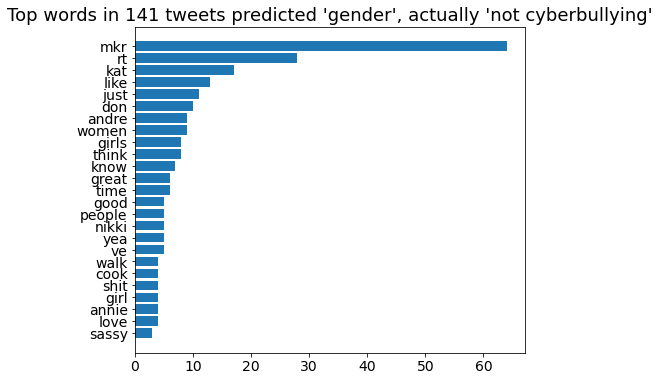

In [470]:
plt.figure(figsize=(7, 6))
plt.title("Top words in 141 tweets predicted 'gender', actually 'not cyberbullying'")
plt.barh(top_25_gender_notcyberbullying['word'],top_25_gender_notcyberbullying[0]);